# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import csv

# TODO: Fill this in based on where you saved the training and testing data
label_file = "signnames.csv";
training_file = "input_data/train.p"
validation_file= "input_data/valid.p"
testing_file = "input_data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_in, y_train_in = train['features'], train['labels']
X_valid_in, y_valid_in = valid['features'], valid['labels']
X_test_in, y_test_in = test['features'], test['labels']

with open(label_file, mode='r') as infile:
    next(infile)  #skip header line 
    reader = csv.reader(infile)
    signame_dict = dict((rows[0],rows[1]) for rows in reader)
    
print("Image Shape: {}".format(X_train_in[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train_in)))
print("Validation Set: {} samples".format(len(X_valid_in)))
print("Test Set:       {} samples".format(len(X_test_in)))

Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = len(X_train_in)

# Number of validation examples
n_validation = len(X_valid_in)

# Number of testing examples.
n_test = len(X_test_in)

# What's the shape of an traffic sign image?
image_shape = X_train_in[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = max(y_train_in) - min(y_train_in) + 1

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of training examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

36  -  Go straight or right


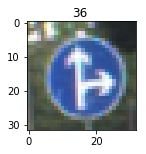

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import numpy as np

index = random.randint(0, len(X_train_in))
image = X_train_in[index].squeeze()

fig = plt.figure(figsize=(2,2))
plt.imshow(image)
fig.suptitle(str(y_train_in[index]))

print(y_train_in[index], " - ", signame_dict[str(y_train_in[index])])

----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set

1. Grayscale
2. Extend Training set with two gamma-corrections (0.5, 2) of grayscale-training-set
3. Normalize values to the range between -1 and 1 

In [18]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
import cv2

def rgb2gray(rgb):
    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    gray = np.expand_dims(gray, axis=3) 
    return gray

# From: http://py-fu.blogspot.co.at/2014/04/simple-gamma-correction-with-opencv.html
def gamma_correction(img, correction):
    img = img/255.0
    img = cv2.pow(img, correction)
    return np.uint8(img*255)

X_train = rgb2gray(X_train_in)
X_valid = rgb2gray(X_valid_in)
X_test = rgb2gray(X_test_in)
y_train = y_train_in
y_valid = y_valid_in
y_test = y_test_in

# Concatenate training set with gamma_corrected variations of itself
X_train = np.concatenate((X_train, gamma_correction(X_train, 0.5), gamma_correction(X_train, 2)), axis=0)
y_train = np.concatenate((y_train, y_train, y_train), axis=0)

X_train = (X_train-128.0)/128.0
X_valid = (X_valid-128.0)/128.0
X_test  = (X_test-128.0)/128.0

print("New Number of training examples =", len(X_train))

New Number of training examples = 104397


36  -  Go straight or right


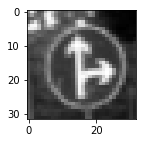

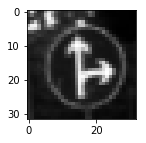

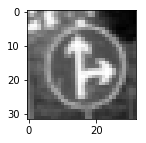

In [5]:
# Plot preprocessed input images

fig = plt.figure(figsize=(2,2))
plt.imshow(X_train[index].squeeze(), cmap="gray")

fig = plt.figure(figsize=(2,2))
plt.imshow(X_train[index+2*len(X_train_in)].squeeze(), cmap="gray")

fig = plt.figure(figsize=(2,2))
plt.imshow(X_train[index+1*len(X_train_in)].squeeze(), cmap="gray")

print(y_train[index], " - ", signame_dict[str(y_train[index])])


### Model Architecture

In [6]:
# Setup tensorflow

import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 100

In [7]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.07
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, 0.8)    

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, 0.8)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [8]:
# Features and Lables

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
# Training pipeline

rate = 0.0005

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [10]:
# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [11]:
X_train, y_train = shuffle(X_train, y_train)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        training_accuracy = evaluate(X_train, y_train)
        print("Training Accuracy = {:.3f}".format(training_accuracy))        
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.773
Training Accuracy = 0.801

EPOCH 2 ...
Validation Accuracy = 0.851
Training Accuracy = 0.885

EPOCH 3 ...
Validation Accuracy = 0.888
Training Accuracy = 0.926

EPOCH 4 ...
Validation Accuracy = 0.895
Training Accuracy = 0.939

EPOCH 5 ...
Validation Accuracy = 0.906
Training Accuracy = 0.953

EPOCH 6 ...
Validation Accuracy = 0.915
Training Accuracy = 0.962

EPOCH 7 ...
Validation Accuracy = 0.921
Training Accuracy = 0.964

EPOCH 8 ...
Validation Accuracy = 0.915
Training Accuracy = 0.969

EPOCH 9 ...
Validation Accuracy = 0.928
Training Accuracy = 0.973

EPOCH 10 ...
Validation Accuracy = 0.924
Training Accuracy = 0.975

EPOCH 11 ...
Validation Accuracy = 0.936
Training Accuracy = 0.978

EPOCH 12 ...
Validation Accuracy = 0.934
Training Accuracy = 0.980

EPOCH 13 ...
Validation Accuracy = 0.928
Training Accuracy = 0.982

EPOCH 14 ...
Validation Accuracy = 0.935
Training Accuracy = 0.983

EPOCH 15 ...
Validation Accuracy = 0.944
Tra

### Test the Model

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.924


---

## Step 3: Test a Model on New Images



### Load and Output the Images

(5, 32, 32, 3)
['01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg']


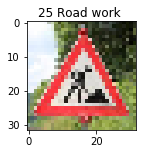

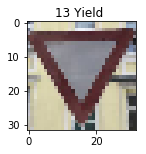

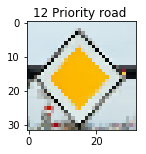

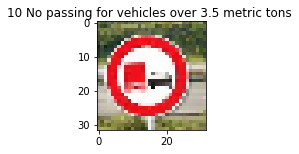

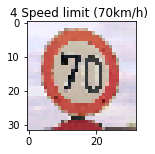

In [13]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab as pl
import cv2
from PIL import Image

input_dir = "web_traffic_signs/";
images = ['01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg']#, '06.jpg', '07.jpg', '08.jpg', '09.jpg']
Y_my_test = [25, 13, 12, 10, 4]#, 33, 38, 13, 37]

img_array = np.empty((len(images), 32, 32, 3), np.float32)
print(img_array.shape)
print(images)

for i in range(len(images)):
    image_in = mpimg.imread(input_dir+images[i])
    image_in = cv2.resize(image_in, (32, 32));

    fig = plt.figure(figsize=(2,2))
    plt.imshow(image_in.squeeze())
    fig.suptitle(str(str(Y_my_test[i]) + " " + signame_dict[str(Y_my_test[i])]))
    img_array[i] =  image_in;
    
X_my_test=  rgb2gray(img_array)
X_my_test = (X_my_test-128.0)/128.0

### Predict the Sign Type for Each Image

In [14]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
test_output = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    output = sess.run(test_output, feed_dict={x: X_my_test})

    for i in range(len(X_my_test)):
        
        if (Y_my_test[i] == output[i]):
            ok_str = "OK"
        else:
            ok_str = "NOT OK"
        print("  {}: {}, {} -> {}".format(images[i], output[i], signame_dict[str(Y_my_test[i])],ok_str))

  01.jpg: 25, Road work -> OK
  02.jpg: 13, Yield -> OK
  03.jpg: 12, Priority road -> OK
  04.jpg: 10, No passing for vehicles over 3.5 metric tons -> OK
  05.jpg: 4, Speed limit (70km/h) -> OK


### Analyze Performance

In [15]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_my_test, Y_my_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


Test Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [16]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
test_output = tf.nn.softmax(logits)
test_output = tf.nn.top_k(test_output, 5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    output = sess.run(test_output, feed_dict={x: X_my_test})

    for i in range(len(X_my_test)):
        print("Test image:", images[i])
        for a,b in zip(output[1][i],output[0][i]):
            print("  {}, {}: {:.3f}%".format(a, signame_dict[str(a)],b*100))


Test image: 01.jpg
  25, Road work: 100.000%
  38, Keep right: 0.000%
  0, Speed limit (20km/h): 0.000%
  1, Speed limit (30km/h): 0.000%
  2, Speed limit (50km/h): 0.000%
Test image: 02.jpg
  13, Yield: 100.000%
  15, No vehicles: 0.000%
  33, Turn right ahead: 0.000%
  0, Speed limit (20km/h): 0.000%
  1, Speed limit (30km/h): 0.000%
Test image: 03.jpg
  12, Priority road: 100.000%
  0, Speed limit (20km/h): 0.000%
  1, Speed limit (30km/h): 0.000%
  2, Speed limit (50km/h): 0.000%
  3, Speed limit (60km/h): 0.000%
Test image: 04.jpg
  10, No passing for vehicles over 3.5 metric tons: 100.000%
  9, No passing: 0.000%
  23, Slippery road: 0.000%
  0, Speed limit (20km/h): 0.000%
  1, Speed limit (30km/h): 0.000%
Test image: 05.jpg
  4, Speed limit (70km/h): 99.937%
  1, Speed limit (30km/h): 0.046%
  5, Speed limit (80km/h): 0.017%
  2, Speed limit (50km/h): 0.000%
  3, Speed limit (60km/h): 0.000%
